In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📏 Median duration: 5.00 seconds
🗣️ Word-level samples: 107
🗣️ Sentence-level samples: 73
🗣️ Word-level Accuracy: 95.45%
🗣️ Sentence-level Accuracy: 100.00%


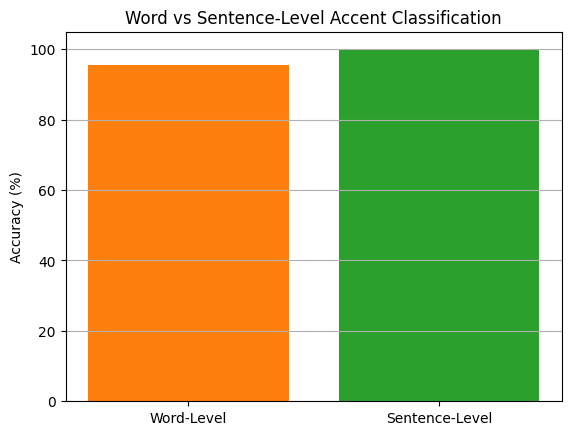

In [2]:
# ----------------------------------------------------------
# 📘 4B_Linguistic_Level_Generalization.ipynb
# ----------------------------------------------------------

from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

DATA_PATH = "/content/drive/MyDrive/Accent1/Accent-Aware-Cuisine-Recommendation/IndicAccentDB"

durations, features, labels = [], [], []
for label, state in enumerate(sorted(os.listdir(DATA_PATH))):
    folder = os.path.join(DATA_PATH, state)
    for file in os.listdir(folder)[:30]:  # sample 30 per state
        if file.endswith(".wav"):
            try:
                wav_path = os.path.join(folder, file)
                y, sr = librosa.load(wav_path, sr=16000)
                dur = librosa.get_duration(y=y, sr=sr)
                durations.append(dur)
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
                mfcc_mean = np.mean(mfcc, axis=1)
                features.append(mfcc_mean)
                labels.append(label)
            except Exception as e:
                continue

features = np.array(features)
labels = np.array(labels)
durations = np.array(durations)

# Use median duration as cutoff
median_dur = np.median(durations)
print(f"📏 Median duration: {median_dur:.2f} seconds")

word_idx = np.where(durations <= median_dur)[0]
sent_idx = np.where(durations > median_dur)[0]

X_word, y_word = features[word_idx], labels[word_idx]
X_sent, y_sent = features[sent_idx], labels[sent_idx]

print(f"🗣️ Word-level samples: {len(X_word)}")
print(f"🗣️ Sentence-level samples: {len(X_sent)}")

# Check
if len(X_word) < 5 or len(X_sent) < 5:
    raise ValueError("⚠️ Not enough samples for one of the groups! Try adjusting duration threshold.")

scaler = StandardScaler()
model_word = RandomForestClassifier(n_estimators=200, random_state=42)
model_sent = RandomForestClassifier(n_estimators=200, random_state=42)

Xw_train, Xw_test, yw_train, yw_test = train_test_split(X_word, y_word, test_size=0.2, random_state=42)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_sent, y_sent, test_size=0.2, random_state=42)

Xw_train = scaler.fit_transform(Xw_train)
Xw_test = scaler.transform(Xw_test)
Xs_train = scaler.fit_transform(Xs_train)
Xs_test = scaler.transform(Xs_test)

model_word.fit(Xw_train, yw_train)
model_sent.fit(Xs_train, ys_train)

yw_pred = model_word.predict(Xw_test)
ys_pred = model_sent.predict(Xs_test)

word_acc = accuracy_score(yw_test, yw_pred)
sent_acc = accuracy_score(ys_test, ys_pred)

print(f"🗣️ Word-level Accuracy: {word_acc*100:.2f}%")
print(f"🗣️ Sentence-level Accuracy: {sent_acc*100:.2f}%")

plt.bar(["Word-Level", "Sentence-Level"], [word_acc*100, sent_acc*100], color=["#ff7f0e", "#2ca02c"])
plt.ylabel("Accuracy (%)")
plt.title("Word vs Sentence-Level Accent Classification")
plt.grid(axis="y")
plt.show()
